In [6]:
import torch
import random
import zipfile

with zipfile.ZipFile('./data/jaychou_lyrics.txt.zip') as zin:
    with zin.open('jaychou_lyrics.txt') as f:
        corpus_chars = f.read().decode('utf-8')
corpus_chars[:80]

'想要有直升机\n想要和你飞到宇宙去\n想要和你融化在一起\n融化在宇宙里\n我每天每天每天在想想想想著你\n这样的甜蜜\n让我开始乡相信命运\n感谢地心引力\n让我碰到你\n漂亮'

这个数据集有6万多个字符。为了打印方便，我们把换行符替换成空格，然后仅使用前1万个字符来训练模型。

In [7]:
corpus_chars = corpus_chars.replace('\n', ' ').replace('\r', ' ')
corpus_chars = corpus_chars[0:10000]


## 建立字符索引

我们将每个字符映射成一个从0开始的连续整数，又称索引，来方便之后的数据处理。为了得到索引，我们将数据集里所有不同字符取出来，然后将其逐一映射到索引来构造词典。接着，打印vocab_size，即词典中不同字符的个数，又称词典大小。

In [10]:
idx_to_char = list(set(corpus_chars))

len(idx_to_char)

1027

In [13]:
#加上序号
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])


In [15]:
vocab_size = len(char_to_idx)
vocab_size 

1027

In [16]:
corpus_indices = [char_to_idx[char] for char in corpus_chars]
sample = corpus_indices[:20]
print('chars:', ''.join([idx_to_char[idx] for idx in sample]))
print('indices:', sample)

chars: 想要有直升机 想要和你飞到宇宙去 想要和
indices: [21, 881, 924, 411, 501, 626, 1017, 21, 881, 301, 978, 113, 754, 205, 510, 546, 1017, 21, 881, 301]


In [17]:
def data_iter_random(corpus_indices,batch_size,num_steps,device=None):
    # 减1是因为输出的索引x是相应输入的索引y加1
    num_examples = (len(corpus_indices) - 1) // num_steps
    epoch_size = num_examples // batch_size
    example_indices = list(range(num_examples))
    random.shuffle(example_indices)
     # 返回从pos开始的长为num_steps的序列
    def _data(pos):
        return corpus_indices[pos: pos + num_steps]
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i in range(epoch_size):
        # 每次读取batch_size个随机样本
        i = i * batch_size
        batch_indices = example_indices[i: i + batch_size]
        X = [_data(j * num_steps) for j in batch_indices]
        Y = [_data(j * num_steps + 1) for j in batch_indices]
        yield torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(Y, dtype=torch.float32, device=device)
    

让我们输入一个从0到29的连续整数的人工序列。设批量大小和时间步数分别为2和6。打印随机采样每次读取的小批量样本的输入X和标签Y。可见，相邻的两个随机小批量在原始序列上的位置不一定相毗邻。

In [18]:
my_seq = list(range(30))
for X, Y in data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y, '\n')

X:  tensor([[18., 19., 20., 21., 22., 23.],
        [ 6.,  7.,  8.,  9., 10., 11.]]) 
Y: tensor([[19., 20., 21., 22., 23., 24.],
        [ 7.,  8.,  9., 10., 11., 12.]]) 

X:  tensor([[12., 13., 14., 15., 16., 17.],
        [ 0.,  1.,  2.,  3.,  4.,  5.]]) 
Y: tensor([[13., 14., 15., 16., 17., 18.],
        [ 1.,  2.,  3.,  4.,  5.,  6.]]) 



In [19]:
def data_iter_consecutive(corpus_indices, batch_size, num_steps, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    corpus_indices = torch.tensor(corpus_indices, dtype=torch.float32, device=device)
    data_len = len(corpus_indices)
    batch_len = data_len // batch_size
    indices = corpus_indices[0: batch_size*batch_len].view(batch_size, batch_len)
    epoch_size = (batch_len - 1) // num_steps
    for i in range(epoch_size):
        i = i * num_steps
        X = indices[:, i: i + num_steps]
        Y = indices[:, i + 1: i + num_steps + 1]
        yield X, Y

In [20]:
for X, Y in data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y, '\n')

X:  tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [15., 16., 17., 18., 19., 20.]]) 
Y: tensor([[ 1.,  2.,  3.,  4.,  5.,  6.],
        [16., 17., 18., 19., 20., 21.]]) 

X:  tensor([[ 6.,  7.,  8.,  9., 10., 11.],
        [21., 22., 23., 24., 25., 26.]]) 
Y: tensor([[ 7.,  8.,  9., 10., 11., 12.],
        [22., 23., 24., 25., 26., 27.]]) 



In [23]:
import time
import math
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
def one_hot(x, n_class, dtype=torch.float32): 
    # X shape: (batch), output shape: (batch, n_class)
    x = x.long()
    res = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)
    res.scatter_(1, x.view(-1, 1), 1)
    return res

x = torch.tensor([0, 2])
print(len(x))
one_hot(x, vocab_size)


2


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [27]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def to_onehot(X, n_class):  
    # X shape: (batch, seq_len), output: seq_len elements of (batch, n_class)
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]



In [29]:
X = torch.arange(10).view(2, 5)
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [31]:
inputs = to_onehot(X, vocab_size)
print(len(inputs), inputs[0].shape)
inputs

5 torch.Size([2, 1027])


[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [32]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device, requires_grad=True))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, requires_grad=True))
    return nn.ParameterList([W_xh, W_hh, b_h, W_hq, b_q])


will use cpu


## 定义模型

我们根据循环神经网络的计算表达式实现该模型。首先定义init_rnn_state函数来返回初始化的隐藏状态。它返回由一个形状为(批量大小, 隐藏单元个数)的值为0的NDArray组成的元组。使用元组是为了更便于处理隐藏状态含有多个NDArray的情况。

In [33]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )


In [34]:
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)


In [35]:
state = init_rnn_state(X.shape[0], num_hiddens, device)
inputs = to_onehot(X.to(device), vocab_size)
params = get_params()
outputs, state_new = rnn(inputs, state, params)
print(len(outputs), outputs[0].shape, state_new[0].shape) 


5 torch.Size([2, 1027]) torch.Size([2, 256])


In [36]:
state = init_rnn_state(X.shape[0], num_hiddens, device)
inputs = to_onehot(X.to(device), vocab_size)
params = get_params()
outputs, state_new = rnn(inputs, state, params)
print(len(outputs), outputs[0].shape, state_new[0].shape) 


5 torch.Size([2, 1027]) torch.Size([2, 256])


## 定义预测函数

In [37]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])


In [38]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)


'分开掩恨酸秃背地雕种出目'

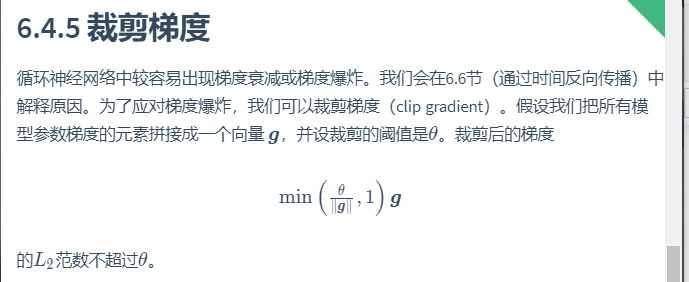

In [39]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

            

In [40]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = d2l.data_iter_random
    else:
        data_iter_fn = d2l.data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  
            # 否则需要使用detach函数从计算图分离隐藏状态, 这是为了
            # 使模型参数的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                for s in state:
                    s.detach_()

            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # batch * num_steps 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y, 0, 1).contiguous().view(-1)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())

            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            d2l.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))


In [41]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']


In [42]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)


epoch 50, perplexity 69.682074, time 1.88 sec
 - 分开 我不要再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我不能再想 我
 - 不分开 你子的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱
epoch 100, perplexity 9.611820, time 1.64 sec
 - 分开 一直在停留 一朵都停 在小怕空的溪边 默默等待 娘子心有 在一场空 在一场容 在一场梦 不要了容 
 - 不分开吗 我已 我不 我不要 爱情走的太快就像龙卷风 不能承受我已无 从小棍耳濡目的 我有你的有写在西元前
epoch 150, perplexity 2.808311, time 1.77 sec
 - 分开 那只心不过走 再多年以我 一只一口四掉而香 试图了夕阳飞翔 带领你我环绕大来找 迎著风 开始共渡每
 - 不分开扫 我的你却 在我已外 却人耿空 你的没空 在底了容 你给的梦 一敢方 快墟的在 随红准备 一人落空
epoch 200, perplexity 1.574547, time 1.65 sec
 - 分开 那直的美丽面的 爱你 没子 我马儿有些瘦 世事尽头 江脸上潮起寞 哼哼哈兮 如使用双截棍 哼哼哈兮
 - 不分开期 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 还是
epoch 250, perplexity 1.299151, time 1.71 sec
 - 分开 那直这人等在你面记 原成自断形悉 然杰在这里 一限日期 然后将过去 慢慢温习 我该了空生的 后知回
 - 不分开扫 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 你爱
